# Aircraft Detection in Satellite Imagery: Deep Learning Approach
 Introduction to Deep Learning Final

## 1. Introduction and Problem Definition
In this project, I will use convolutional neural netwrks to detect aircraft in satellite imagery. Satellite imagery analysis has become important for various applications including airport activity monitoring, traffic pattern analysis, and defense intelligence. Doing this type of work manually is tedious and automating this process through computer vision has vastly sped it up.

Problem Statement: Develop a deep learning model that can accurately identify the presence of aircraft in satellite imagery. This is formulated as a binary classification problem where each 20x20 RGB image is classified as either containing an aircraft ("plane") or not containing an aircraft ("no-plane").

Project Goals:

- Perform comprehensive exploratory data analysis on the Planes in Satellite Imagery dataset
- Develop and train a custom CNN model for aircraft detection
- Implement transfer learning using a pre-trained ResNet model
- Compare model performances and optimize hyperparameters
- Evaluate models on test data and full satellite scenes

My GitHub repo for this project can be found here: https://github.com/alec-sekelsky/Aircraft-Detection-Final-Project

## 2. Data Collection
The dataset used in this project is the "Planes in Satellite Imagery" dataset from Kaggle. This dataset consists of 32,000 20x20 RGB images extracted from PlanetScope satellite imagery collected over multiple airports in California. Images are orthorectified to a 3-meter pixel size.

The dataset can be found here: https://www.kaggle.com/datasets/rhammell/planesnet

The dataset includes:

- 8,000 "plane" class images (centered on aircraft)
- 24,000 "no-plane" class images (including random land features, partial planes, and challenging negative examples)
- The satellite imagery used to build this dataset is made available through Planet's Open California dataset, which is openly licensed under CC-BY-SA license.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import random
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import resize

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [2]:
# Function to load data from JSON file
def load_json_data(json_path):
    with open(json_path, 'r') as f:
        data_dict = json.load(f)
    
    # Extract data
    pixel_data = np.array(data_dict['data'])
    labels = np.array(data_dict['labels'])
    scene_ids = data_dict['scene_ids']
    locations = data_dict['locations']
    
    # Reshape pixel data to image format
    num_images = len(labels)
    images = np.zeros((num_images, 20, 20, 3), dtype=np.uint8)
    
    for i in range(num_images):
        # Extract RGB channels
        r = pixel_data[i][:400].reshape(20, 20)
        g = pixel_data[i][400:800].reshape(20, 20)
        b = pixel_data[i][800:].reshape(20, 20)
        
        # Combine channels
        images[i] = np.stack([r, g, b], axis=-1)
    
    return images, labels, scene_ids, locations

# Function to load data from PNG files
def load_png_data(directory):
    images = []
    labels = []
    scene_ids = []
    locations = []
    
    for filename in os.listdir(directory):
        if filename.endswith('.png'):
            # Parse filename: {label}_{scene_id}_{longitude}_{latitude}.png
            parts = filename.split('_')
            label = int(parts[0])
            scene_id = parts[1]
            location = '_'.join(parts[2:]).replace('.png', '')
            
            # Load image
            img_path = os.path.join(directory, filename)
            img = np.array(Image.open(img_path))
            
            images.append(img)
            labels.append(label)
            scene_ids.append(scene_id)
            locations.append(location)
    
    return np.array(images), np.array(labels), scene_ids, locations

# Load json data
data_path = 'planesnet.json'  
images, labels, scene_ids, locations = load_json_data(data_path)

print(f"Dataset loaded: {len(images)} images with shape {images[0].shape}")
print(f"Class distribution: {np.sum(labels)} planes, {len(labels) - np.sum(labels)} no-planes")

Dataset loaded: 32000 images with shape (20, 20, 3)
Class distribution: 8000 planes, 24000 no-planes


## 3. Exploratory Data Analysis (EDA)
### 3.1 Basic Dataset Statistics

Class Distribution:
      Class  Count  Percentage
0     Plane   8000        25.0
1  No Plane  24000        75.0


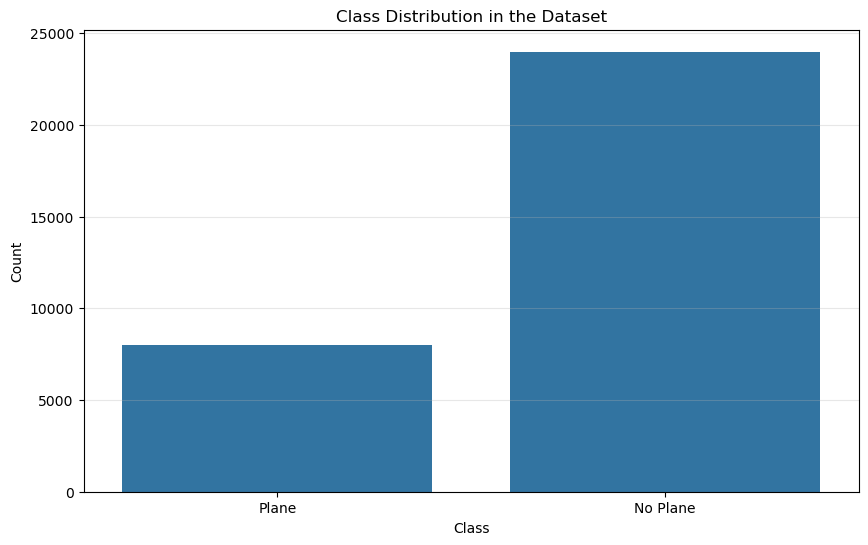


Image Statistics:
Image dimensions: (20, 20, 3)
Pixel value range: Min=1, Max=255
Mean pixel value: 173.00
Standard deviation of pixel values: 49.85


In [3]:
# Display class distribution
plane_count = np.sum(labels)
no_plane_count = len(labels) - plane_count
class_distribution = pd.DataFrame({
    'Class': ['Plane', 'No Plane'],
    'Count': [plane_count, no_plane_count],
    'Percentage': [plane_count/len(labels)*100, no_plane_count/len(labels)*100]
})

print("Class Distribution:")
print(class_distribution)

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Count', data=class_distribution)
plt.title('Class Distribution in the Dataset')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Basic image statistics
print("\nImage Statistics:")
print(f"Image dimensions: {images[0].shape}")
print(f"Pixel value range: Min={images.min()}, Max={images.max()}")
print(f"Mean pixel value: {images.mean():.2f}")
print(f"Standard deviation of pixel values: {images.std():.2f}")

### 3.2 Visualize Sample Images

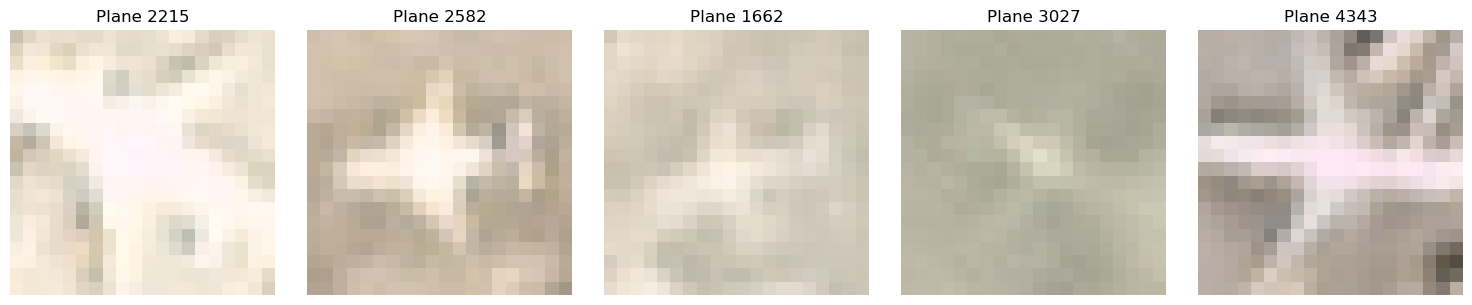

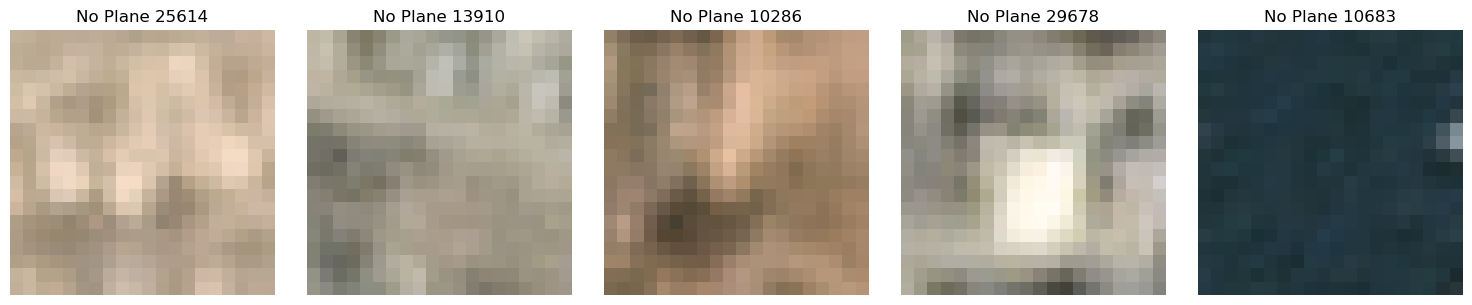

In [4]:
# Function to display sample images
def display_samples(images, labels, num_samples=5, class_name=""):
    indices = np.where(labels == (1 if class_name == "Plane" else 0))[0]
    samples = np.random.choice(indices, num_samples, replace=False)
    
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[idx])
        plt.title(f"{class_name} {idx}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display sample plane images
display_samples(images, labels, num_samples=5, class_name="Plane")

# Display sample no-plane images
display_samples(images, labels, num_samples=5, class_name="No Plane")

### 3.3 Pixel Value Distribution Analysis

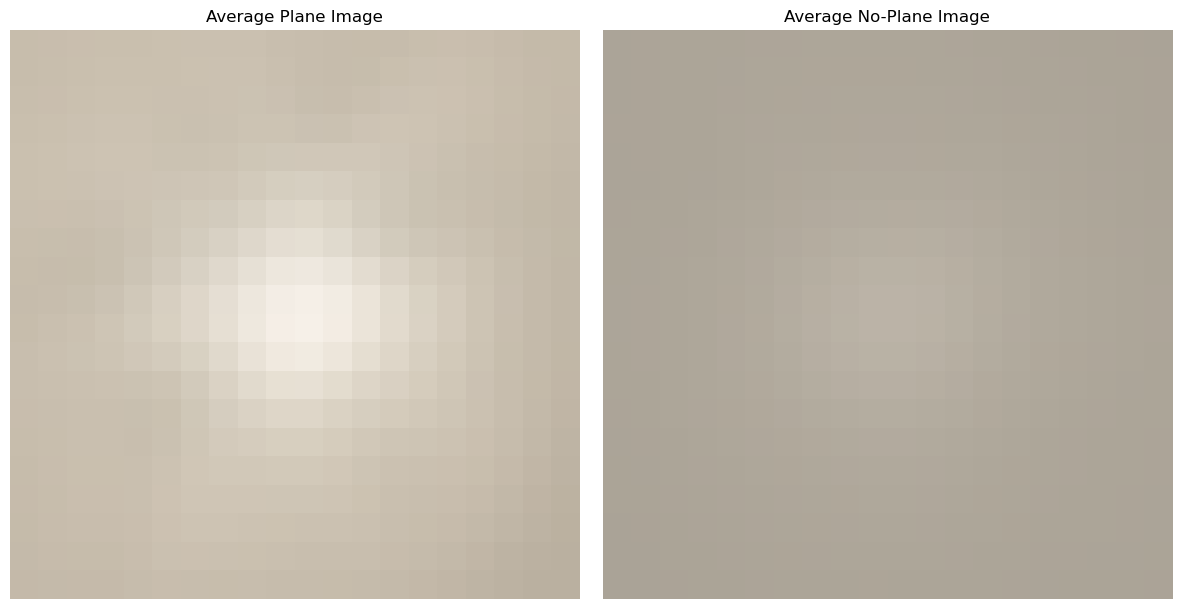

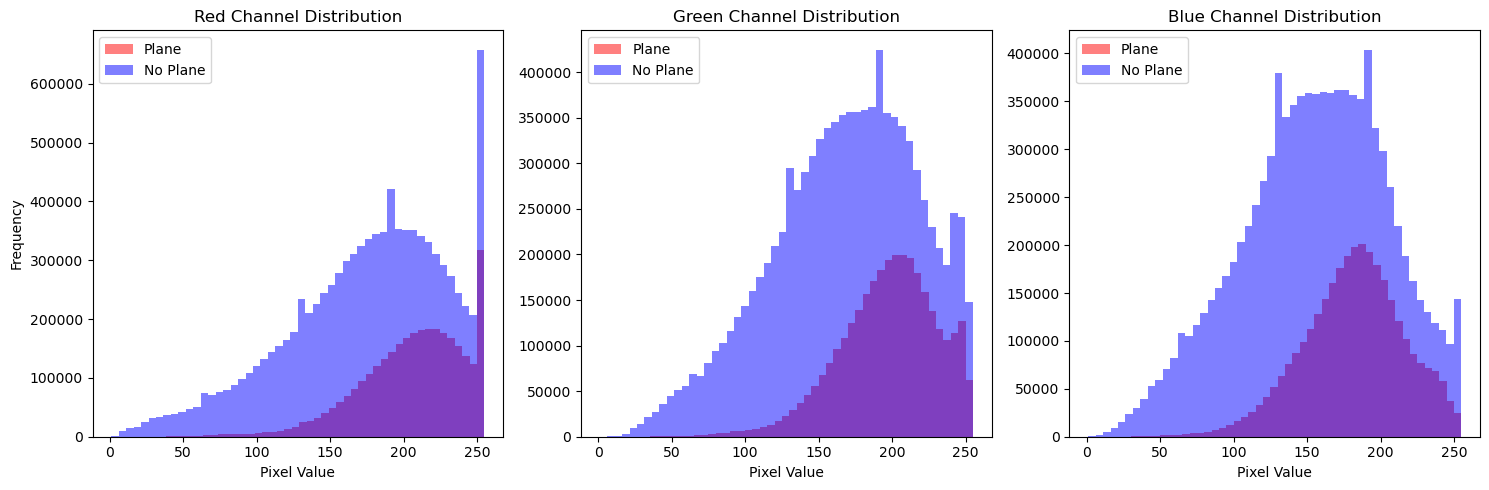

In [5]:
# Analyze pixel value distribution
def analyze_pixel_distribution(images, labels):
    # Separate images by class
    plane_images = images[labels == 1]
    no_plane_images = images[labels == 0]
   
    # Calculate average images
    avg_plane = np.mean(plane_images, axis=0).astype(np.uint8)
    avg_no_plane = np.mean(no_plane_images, axis=0).astype(np.uint8)
   
    # Plot average images
    plt.figure(figsize=(12, 6))
   
    plt.subplot(1, 2, 1)
    plt.imshow(avg_plane)
    plt.title('Average Plane Image')
    plt.axis('off')
   
    plt.subplot(1, 2, 2)
    plt.imshow(avg_no_plane)
    plt.title('Average No-Plane Image')
    plt.axis('off')
   
    plt.tight_layout()
    plt.show()
   
    # Plot histogram of pixel values by channel
    plt.figure(figsize=(15, 5))
   
    # Red channel
    plt.subplot(1, 3, 1)
    plt.hist(plane_images[:, :, :, 0].flatten(), bins=50, alpha=0.5, color='red', label='Plane')
    plt.hist(no_plane_images[:, :, :, 0].flatten(), bins=50, alpha=0.5, color='blue', label='No Plane')
    plt.title('Red Channel Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()
   
    # Green channel
    plt.subplot(1, 3, 2)
    plt.hist(plane_images[:, :, :, 1].flatten(), bins=50, alpha=0.5, color='red', label='Plane')
    plt.hist(no_plane_images[:, :, :, 1].flatten(), bins=50, alpha=0.5, color='blue', label='No Plane')
    plt.title('Green Channel Distribution')
    plt.xlabel('Pixel Value')
    plt.legend()
   
    # Blue channel
    plt.subplot(1, 3, 3)
    plt.hist(plane_images[:, :, :, 2].flatten(), bins=50, alpha=0.5, color='red', label='Plane')
    plt.hist(no_plane_images[:, :, :, 2].flatten(), bins=50, alpha=0.5, color='blue', label='No Plane')
    plt.title('Blue Channel Distribution')
    plt.xlabel('Pixel Value')
    plt.legend()
   
    plt.tight_layout()
    plt.show()
 
# Analyze pixel distribution
analyze_pixel_distribution(images, labels)

### 3.4 Feature Engineering and Analysis

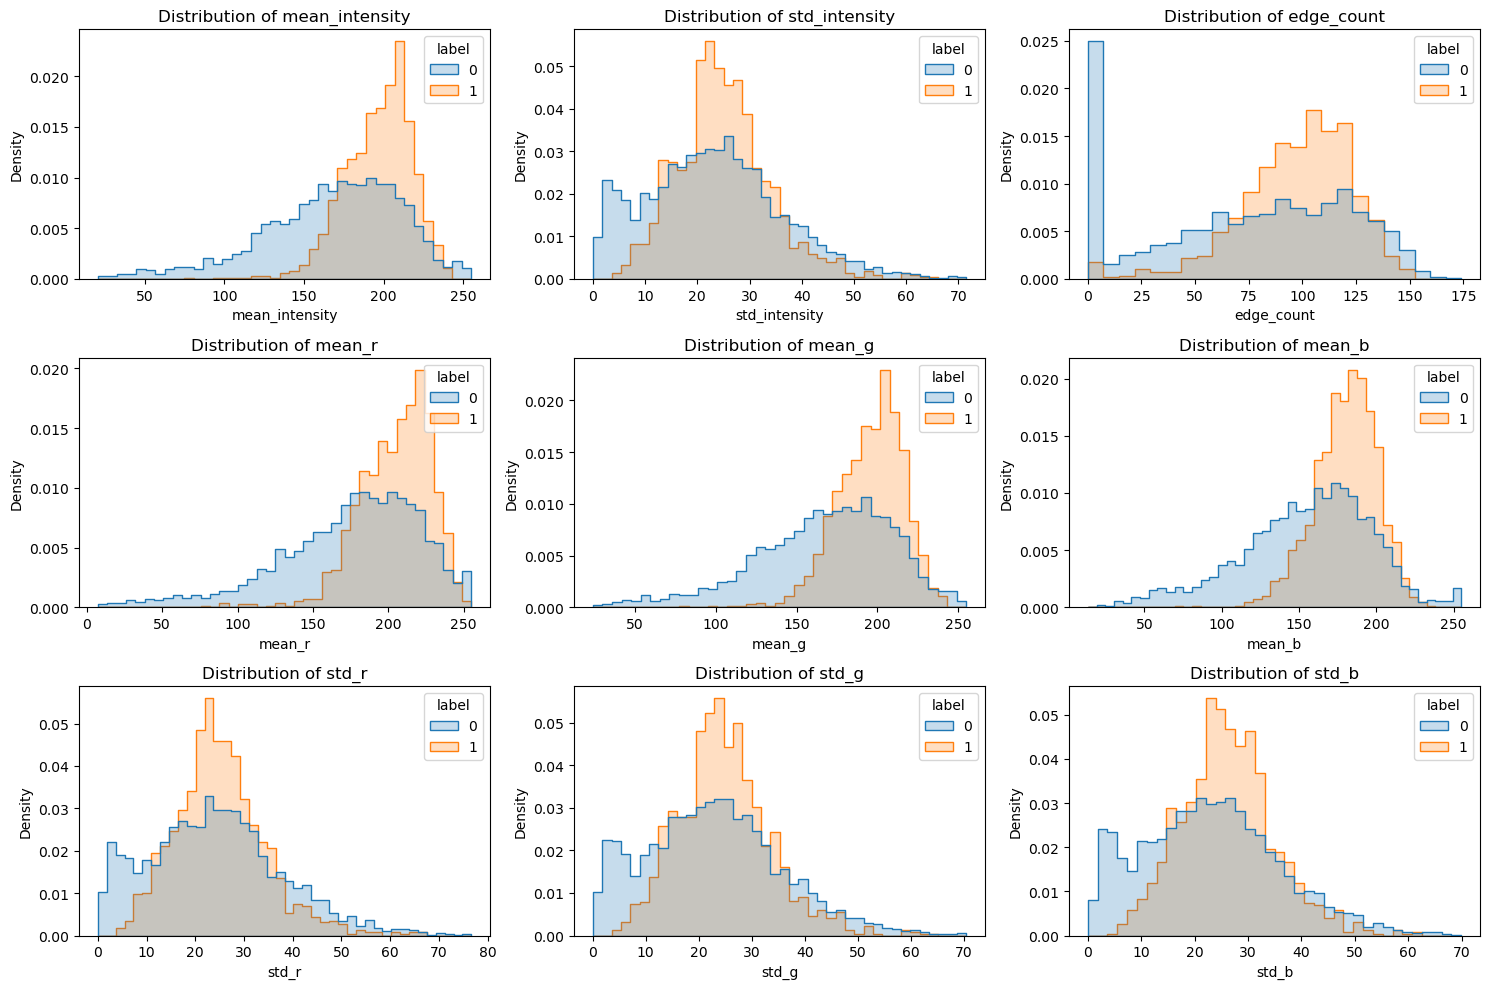

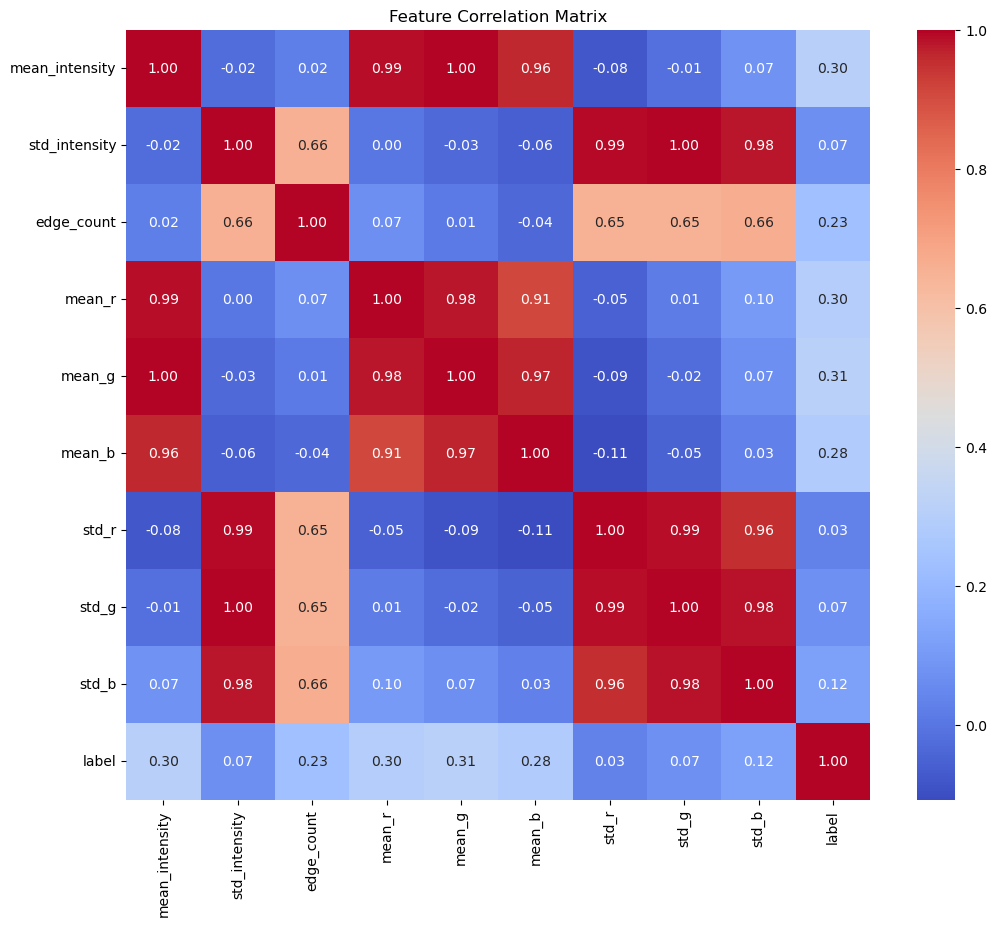

In [6]:
# Function to extract image features
def extract_image_features(images):
    features = []
    
    for img in images:
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Calculate basic statistics
        mean_intensity = np.mean(gray)
        std_intensity = np.std(gray)
        
        # Edge detection
        edges = cv2.Canny(gray, 50, 150)
        edge_count = np.sum(edges > 0)
        
        features.append({
            'mean_intensity': mean_intensity,
            'std_intensity': std_intensity,
            'edge_count': edge_count,
            'mean_r': np.mean(img[:, :, 0]),
            'mean_g': np.mean(img[:, :, 1]),
            'mean_b': np.mean(img[:, :, 2]),
            'std_r': np.std(img[:, :, 0]),
            'std_g': np.std(img[:, :, 1]),
            'std_b': np.std(img[:, :, 2])
        })
    
    return pd.DataFrame(features)

# Extract features for a subset of images (for efficiency)
sample_indices = np.random.choice(len(images), min(5000, len(images)), replace=False)
sample_images = images[sample_indices]
sample_labels = labels[sample_indices]

# Extract features
features_df = extract_image_features(sample_images)
features_df['label'] = sample_labels

# Analyze feature distributions
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features_df.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=features_df, x=feature, hue='label', element='step', stat='density', common_norm=False)
    plt.title(f'Distribution of {feature}')
    
plt.tight_layout()
plt.show()

# Correlation analysis
plt.figure(figsize=(12, 10))
correlation = features_df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

### 3.5 Data Cleaning and Preparation

In [7]:
# Normalize pixel values
X = images.astype('float32') / 255.0
y = labels

# Split data into train, validation, and test sets
# First split into train+val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Then split train+val into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42
)

print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

# Check class distribution in each set
print(f"Training set class distribution: {np.sum(y_train)} planes, {len(y_train) - np.sum(y_train)} no-planes")
print(f"Validation set class distribution: {np.sum(y_val)} planes, {len(y_val) - np.sum(y_val)} no-planes")
print(f"Test set class distribution: {np.sum(y_test)} planes, {len(y_test) - np.sum(y_test)} no-planes")

Training set: 19200 images
Validation set: 6400 images
Test set: 6400 images
Training set class distribution: 4800 planes, 14400 no-planes
Validation set class distribution: 1600 planes, 4800 no-planes
Test set class distribution: 1600 planes, 4800 no-planes


## 4. Model Development and Training
### 4.1 Custom CNN Model

This CNN architecture is designed for the problem in small 20x20 pixel satellite images.

Convolutional Blocks: The model consists of three convolutional blocks, each increasing in depth (32 → 64 → 128 filters) to extract more complex features:

- The first block captures basic features like edges and simple shapes
- The second block identifies more complex patterns like aircraft wings and tails
- The third block recognizes high-level features specific to aircraft

I use 3×3 convolution kernels throughout the network, which are ideal for detecting small features in these smaller pictures. I also use the 'same' padding to keep spatial dimensions after convolutions, due to the small image size.

The model incorporates several regularization strategies to prevent overfitting:

- Batch Normalization: Applied after each convolutional layer to stabilize learning and reduce internal covariate shift
- Dropout: Used at multiple levels (25% in convolutional layers, 50% in dense layers) to prevent co-adaptation of neurons
- MaxPooling: Reduces spatial dimensions while retaining important features, helping with translation invariance
- Output Layer: A single sigmoid neuron for binary classification (plane/no-plane), which outputs a probability between 0 and 1.

Optimization Strategy: I use the Adam optimizer with a learning rate of 0.001, which adapts during training for faster convergence. Binary cross-entropy is the appropriate loss function for this problem.

Performance Metrics: I track accuracy, precision, recall, and AUC. 

In [8]:
def build_custom_cnn(input_shape=(20, 20, 3)):
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        
        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
                 tf.keras.metrics.AUC()]
    )
    
    return model

# Build custom CNN model
custom_cnn = build_custom_cnn()

# Print model summary
custom_cnn.summary()

/Users/alec/miniforge3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-16 18:15:12.945832: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-04-16 18:15:12.945858: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-16 18:15:12.945862: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-16 18:15:12.945892: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-16 18:15:12.945905: I tensorflow/core/common_runtime/pluggable_device/pluggable_de

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 20, 20, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 20, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 20, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 20, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 551,073 (2.10 MB)

 Trainable params: 550,177 (2.10 MB)

 Non-trainable params: 896 (3.50 KB)

### 4.2 Data Augmentation

Data Augmentation Strategy Explanation

This dataset contains only 32,000 images with a class imbalance (8,000 "plane" vs. 24,000 "no-plane" images). This process should increase the size of the training set by creating modified versions of existing images, helping the model generalize better.

I also weigh the classes to address the balance, where the weight is calculated as the ratio of "no-plane" to "plane" samples. The "plane" class keeps a weight of 1. 

I also "add" data to the "plane" class by rotating and moving the images in that class. It also helps prevent overfitting by preventing the model from memorizing the same patterns and see different variations.

I use 'nearest' fill mode so that when transformations create empty areas in the image, they get filled with pixel values from nearby pixels.

Only the test dataset does this get applied. 

Class weights: {0: 1.0, 1: 3.0}


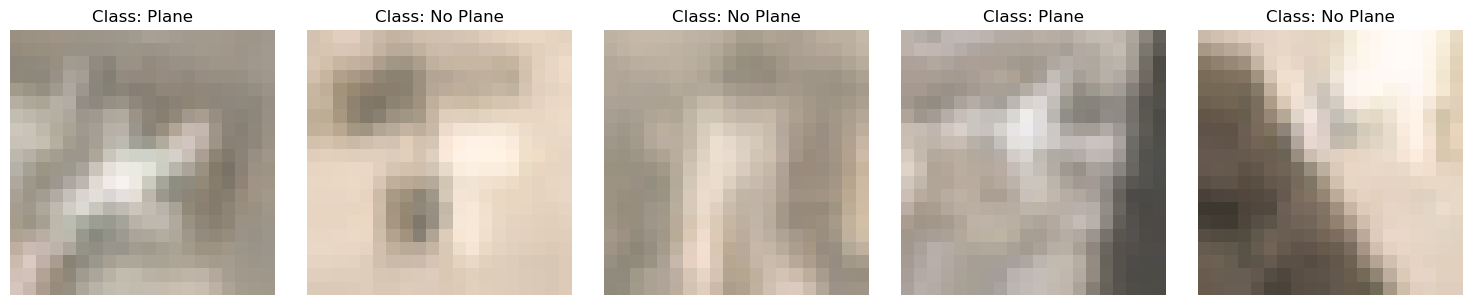

In [9]:
# Create data augmentation generator for the training set
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# For validation and test sets, we only normalize the data
val_datagen = ImageDataGenerator()

# I will use class weights to handle imbalance
class_weight = {
    0: 1.0,
    1: len(y_train[y_train == 0]) / len(y_train[y_train == 1])  # Weight for minority class
}

print(f"Class weights: {class_weight}")

# Create data generators
batch_size = 32
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size, shuffle=False)

# Visualize some augmented images
def show_augmented_images(generator, num_images=5):
    plt.figure(figsize=(15, 3))
    
    # Get a batch of augmented images
    X_batch, y_batch = next(generator)
    
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(X_batch[i])
        plt.title(f"Class: {'Plane' if y_batch[i] == 1 else 'No Plane'}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show some augmented images
show_augmented_images(train_generator)

### 4.3 Training

Epoch 1/50


/Users/alec/miniforge3/envs/tf-metal/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-04-16 18:15:14.200454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 38s 59ms/step - accuracy: 0.7986 - auc: 0.8998 - loss: 0.6432 - precision: 0.5639 - recall: 0.8735 - val_accuracy: 0.7503 - val_auc: 0.9202 - val_loss: 0.6898 - val_precision: 1.0000 - val_recall: 0.0012 - learning_rate: 0.0010
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 34s 56ms/step - accuracy: 0.8951 - auc: 0.9614 - loss: 0.3772 - precision: 0.7343 - recall: 0.9143 - val_accuracy: 0.9055 - val_auc: 0.9878 - val_loss: 0.2102 - val_precision: 0.9816 - val_recall: 0.6338 - learning_rate: 0.0010
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 33s 56ms/step - accuracy: 0.9210 - auc: 0.9764 - loss: 0.2909 - precision: 0.7891 - recall: 0.9309 - val_accuracy: 0.7142 - val_auc: 0.9713 - val_loss: 0.8778 - val_precision: 0.4666 - val_recall: 0.9987 - learning_rate: 0.0010
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 34s 56ms/step - accuracy: 0.9240 - auc: 0.9785 - loss: 0.2768 - precision: 0.7924 - recall: 0.9351 - val_accuracy: 0.9222 - val_auc: 0.9886 - val_loss: 0.1878 - val_pr

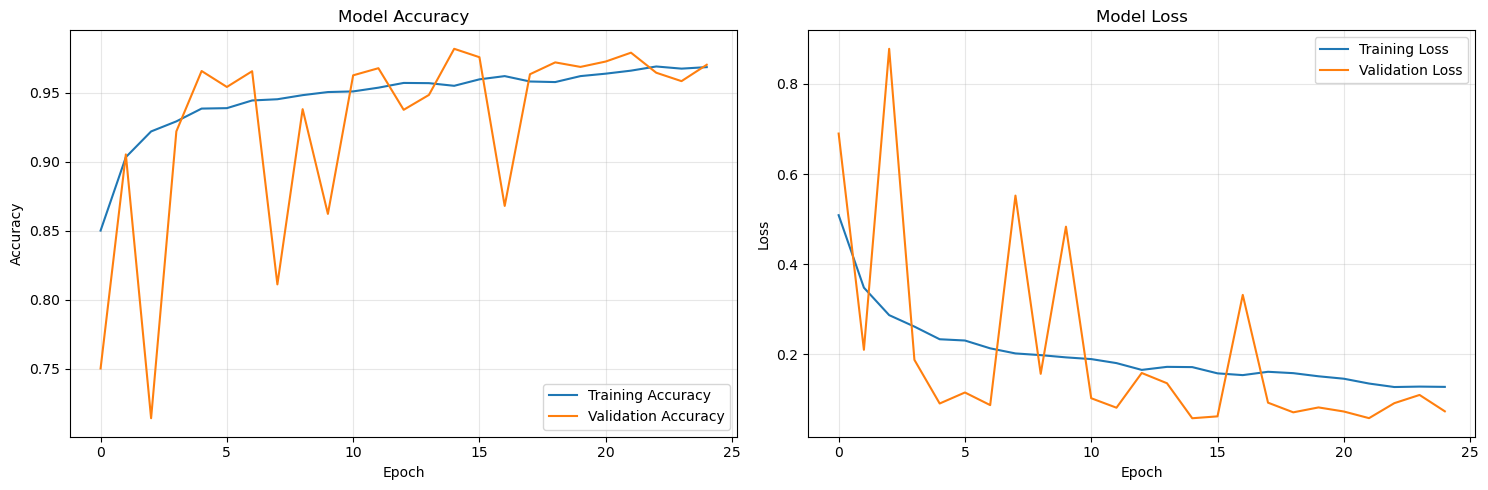

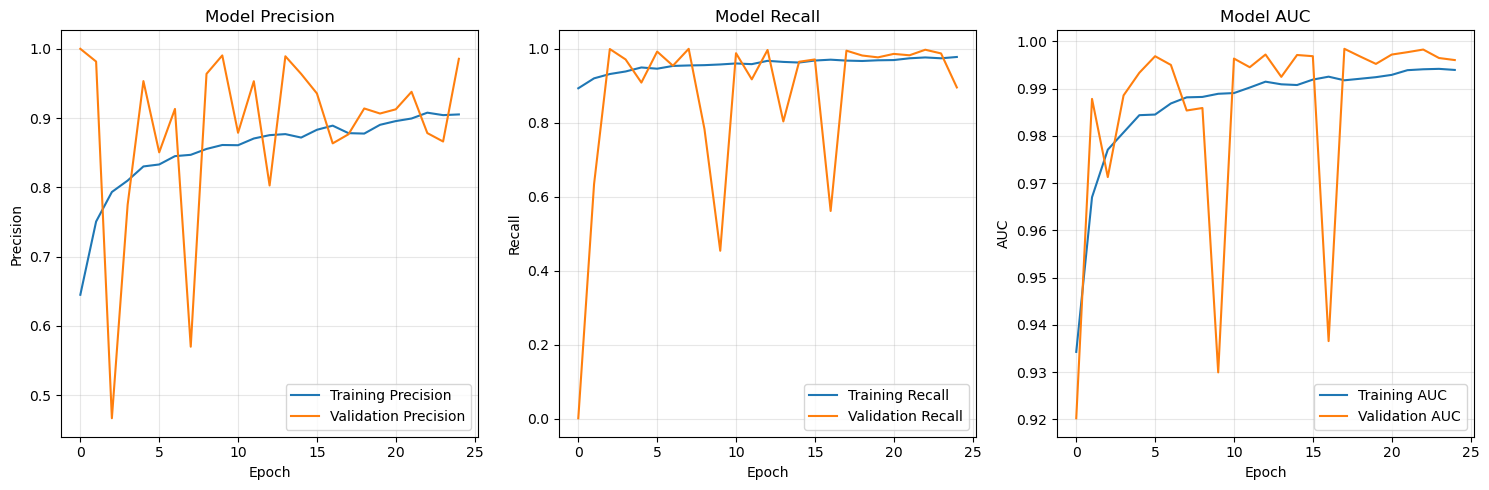

In [10]:
# Set up callbacks for training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_custom_cnn.keras', monitor='val_auc', mode='max', save_best_only=True)
]

# Train the model
epochs = 50
history_custom = custom_cnn.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    class_weight=class_weight
)

# Plot training history
def plot_training_history(history):
    # Metric keys based on model type
    history_keys = history.history.keys()
    
    # Dynamically find the correct keys for precision, recall, and AUC
    precision_key = next((k for k in history_keys if 'precision' in k and not k.startswith('val_')), None)
    recall_key = next((k for k in history_keys if 'recall' in k and not k.startswith('val_')), None)
    auc_key = next((k for k in history_keys if 'auc' in k and not k.startswith('val_')), None)
    
    val_precision_key = next((k for k in history_keys if k.startswith('val_precision')), None)
    val_recall_key = next((k for k in history_keys if k.startswith('val_recall')), None)
    val_auc_key = next((k for k in history_keys if k.startswith('val_auc')), None)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Plot Additional Metrics
    plt.figure(figsize=(15, 5))

    if precision_key and val_precision_key:
        plt.subplot(1, 3, 1)
        plt.plot(history.history[precision_key], label='Training Precision')
        plt.plot(history.history[val_precision_key], label='Validation Precision')
        plt.title('Model Precision')
        plt.xlabel('Epoch')
        plt.ylabel('Precision')
        plt.legend()
        plt.grid(True, alpha=0.3)

    if recall_key and val_recall_key:
        plt.subplot(1, 3, 2)
        plt.plot(history.history[recall_key], label='Training Recall')
        plt.plot(history.history[val_recall_key], label='Validation Recall')
        plt.title('Model Recall')
        plt.xlabel('Epoch')
        plt.ylabel('Recall')
        plt.legend()
        plt.grid(True, alpha=0.3)

    if auc_key and val_auc_key:
        plt.subplot(1, 3, 3)
        plt.plot(history.history[auc_key], label='Training AUC')
        plt.plot(history.history[val_auc_key], label='Validation AUC')
        plt.title('Model AUC')
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history_custom)

### 4.4 Transfer Learning with ResNet
I will implement a transfer learning approach using the pre-trained ResNet50 model:

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 20, 20, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 220, 220, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,537 (91.99 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 156s 253ms/step - accuracy: 0.6560 - auc: 0.7847 - loss: 0.8433 - precision: 0.4096 - recall: 0.8576 - val_accuracy: 0.2703 - val_auc: 0.9037 - val_loss: 2.0744 - val_precision: 0.2552 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 148s 247ms/step - accuracy: 0.7709 - auc: 0.8893 - loss: 0.6529 - precision: 0.5264 - recall: 0.8903 - val_accuracy: 0.4925 - val_auc: 0.9286 - val_loss: 1.0963 - val_precision: 0.3298 - val_recall: 0.9975 - learning_rate: 1.0000e-04
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 148s 246ms/step - accuracy: 0.8007 - auc: 0.9057 - loss: 0.5948 - precision: 0.5647 - recall: 0.8821 - val_accuracy: 0.2884 - val_auc: 0.8253 - val_loss: 3.2426 - val_precision: 0.2600 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 148s 247ms/step - accuracy: 0.8257 - auc: 0.9191 - loss: 0.5486 - precision: 0.6017 - recall: 0.8823 - val_accuracy: 0.8217 - val_auc: 0.9

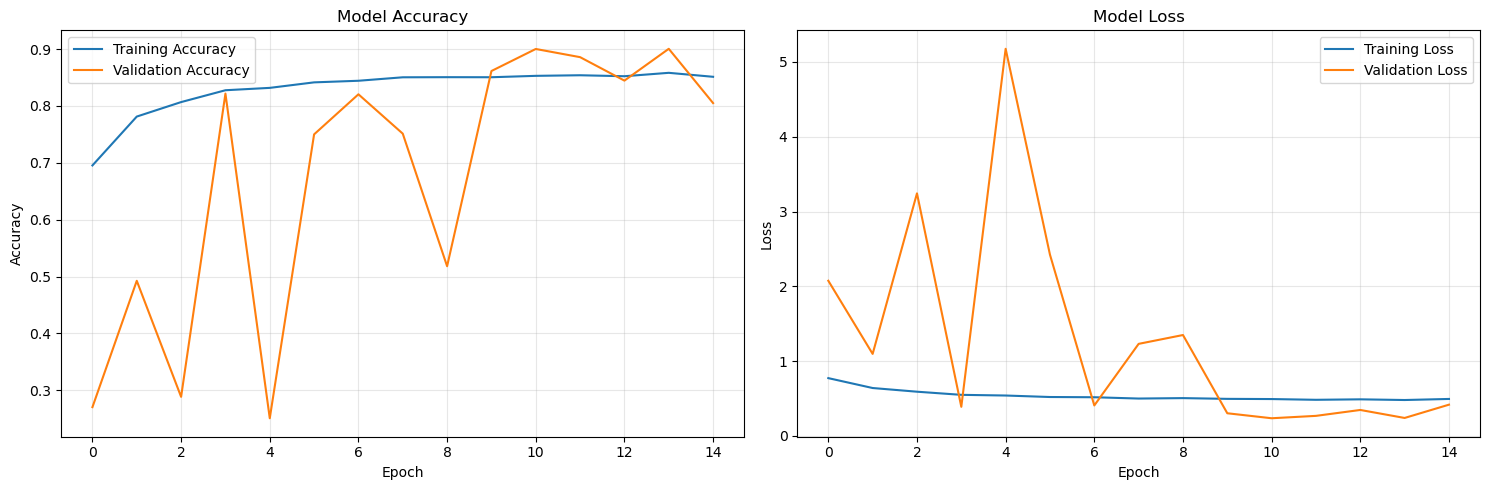

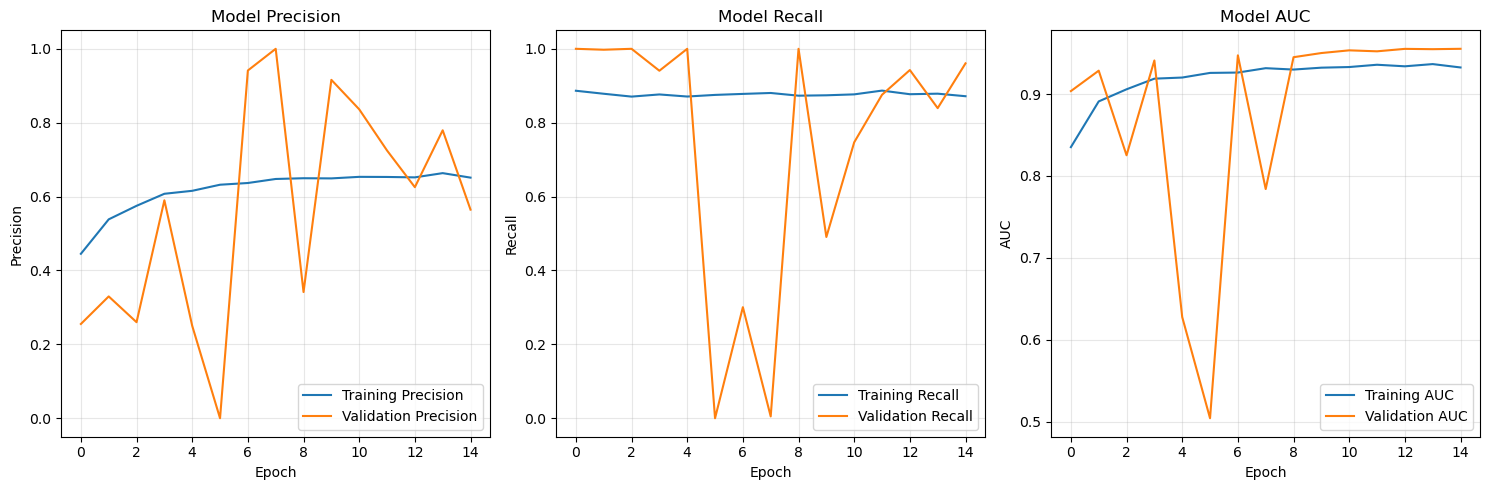

In [11]:
def build_resnet_model(input_shape=(20, 20, 3)):
    # Since ResNet50 expects 224x224 images, I will use a custom input layer
    # and then upsample before feeding to ResNet
    inputs = layers.Input(shape=input_shape)
    
    # Upsample to 224x224
    x = layers.UpSampling2D(size=(11, 11))(inputs)  # 20*11 = 220, close to 224
    x = layers.ZeroPadding2D(padding=(2, 2))(x)     # Pad to reach 224x224
    
    # Load pre-trained ResNet50 without top layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Connect our upsampled input to the base model
    x = base_model(x)
    
    # Add custom classification layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    
    # Create model
    model = models.Model(inputs=inputs, outputs=x)
    
    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

# Build ResNet model
resnet_model = build_resnet_model()

# Print model summary
resnet_model.summary()

# Train ResNet model
callbacks_resnet = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_resnet_model.keras', monitor='val_auc', mode='max', save_best_only=True)
]

history_resnet = resnet_model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=15, 
    validation_data=(X_val, y_val),
    callbacks=callbacks_resnet,
    class_weight=class_weight
)

# Plot training history
plot_training_history(history_resnet)

### 4.6 Hyperparameter Tuning for the Custom CNN


Training model with hyperparameters: {'learning_rate': 0.001, 'dropout_rate': 0.25, 'filters_1': 32, 'filters_2': 64}
Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.8181 - auc_1: 0.9197 - loss: 0.5886 - val_accuracy: 0.9261 - val_auc_1: 0.9742 - val_loss: 0.1958
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.9273 - auc_1: 0.9792 - loss: 0.2759 - val_accuracy: 0.8852 - val_auc_1: 0.9617 - val_loss: 0.3029
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.9448 - auc_1: 0.9868 - loss: 0.2140 - val_accuracy: 0.8587 - val_auc_1: 0.9754 - val_loss: 0.3714
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.9547 - auc_1: 0.9910 - loss: 0.1771 - val_accuracy: 0.8984 - val_auc_1: 0.9872 - val_loss: 0.2857
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.9630 - auc_1: 0.9933 - loss: 0.1482 - val_accuracy: 0.9591 - val_auc_1: 0.9951 - val_loss: 0.1023
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/st

/Users/alec/miniforge3/envs/tf-metal/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - accuracy: 0.8797 - auc_4: 0.9517 - loss: 0.4343 - val_accuracy: 0.9289 - val_auc_4: 0.9847 - val_loss: 0.1860 - learning_rate: 5.0000e-04
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - accuracy: 0.8947 - auc_4: 0.9610 - loss: 0.3815 - val_accuracy: 0.9250 - val_auc_4: 0.9928 - val_loss: 0.1966 - learning_rate: 5.0000e-04
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - accuracy: 0.9124 - auc_4: 0.9745 - loss: 0.3069 - val_accuracy: 0.7603 - val_auc_4: 0.9448 - val_loss: 0.7083 - learning_rate: 5.0000e-04
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - accuracy: 0.9208 - auc_4: 0.9759 - loss: 0.2966 - val_accuracy: 0.9345 - val_auc_4: 0.9867 - val_loss: 0.1597 - learning_rate: 5.0000e-04
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - accuracy: 0.9233 - auc_4: 0.9768 - loss: 0.2884 - val_accuracy: 0.9303 - val_auc_4: 0.9918 - val_loss: 0.1813 - learning_rate: 5.0000e-04
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2

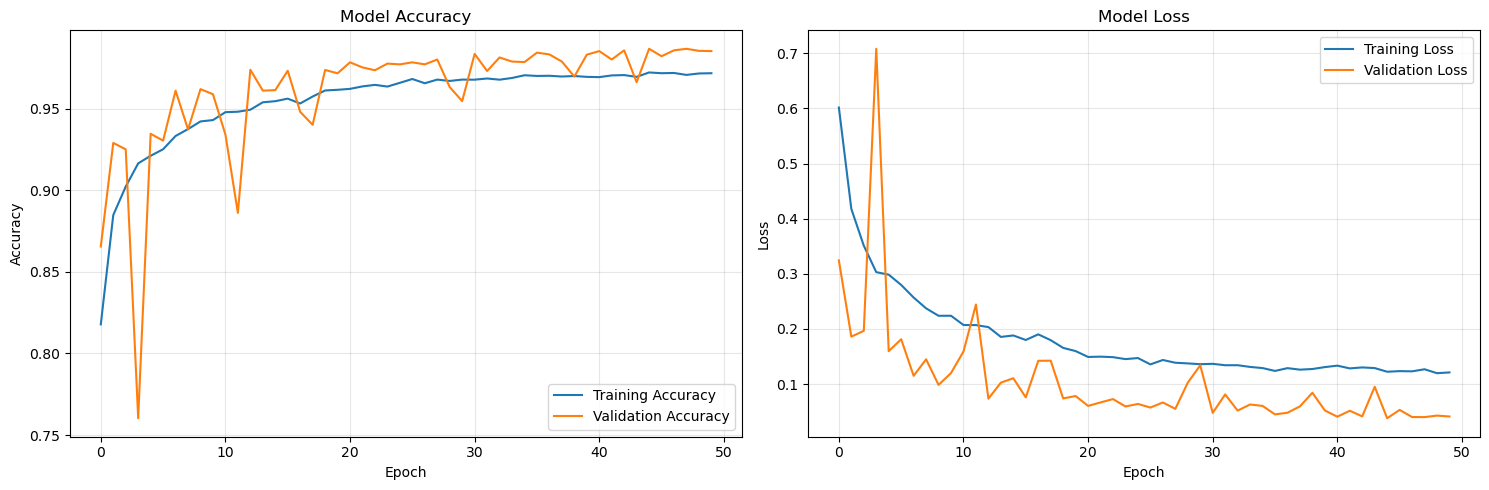

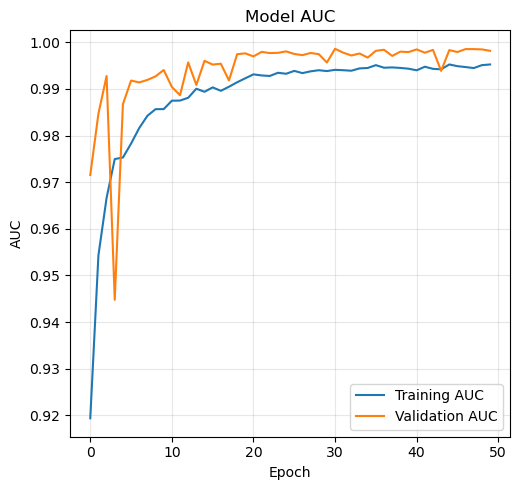

In [12]:
def build_tunable_cnn(learning_rate=0.001, dropout_rate=0.25, filters_1=32, filters_2=64):
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(filters_1, (3, 3), activation='relu', padding='same', input_shape=(20, 20, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(filters_1, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),
        
        # Second convolutional block
        layers.Conv2D(filters_2, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(filters_2, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),
        
        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate * 2),  # Higher dropout for dense layers
        layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

# Define hyperparameter combinations to try
hyperparameters = [
    {'learning_rate': 0.001, 'dropout_rate': 0.25, 'filters_1': 32, 'filters_2': 64},
    {'learning_rate': 0.0005, 'dropout_rate': 0.3, 'filters_1': 48, 'filters_2': 96},
    {'learning_rate': 0.0001, 'dropout_rate': 0.4, 'filters_1': 64, 'filters_2': 128}
]

# Train models with different hyperparameters
tuning_results = []

for i, params in enumerate(hyperparameters):
    print(f"\nTraining model with hyperparameters: {params}")
    
    # Build model with these hyperparameters
    tunable_model = build_tunable_cnn(**params)
    
    # Set up callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
    
    # Train the model
    history = tunable_model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=20,  # Fewer epochs for hyperparameter search
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        class_weight=class_weight,
        verbose=1
    )
    
    # Evaluate on validation set
    val_loss, val_acc, val_auc = tunable_model.evaluate(X_val, y_val, verbose=0)
    
    # Store results
    tuning_results.append({
        'params': params,
        'val_loss': val_loss,
        'val_accuracy': val_acc,
        'val_auc': val_auc
    })
    
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}")

# Find the best hyperparameters
best_idx = np.argmax([result['val_auc'] for result in tuning_results])
best_params = tuning_results[best_idx]['params']
print(f"\nBest hyperparameters: {best_params}")
print(f"Best validation AUC: {tuning_results[best_idx]['val_auc']:.4f}")

# Train final model with best hyperparameters
final_custom_model = build_tunable_cnn(**best_params)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_tuned_cnn.keras', monitor='val_auc', mode='max', save_best_only=True)
]

# Train the final model with the best hyperparameters
history_tuned = final_custom_model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    class_weight=class_weight
)

# Plot training history
plot_training_history(history_tuned)

## 5. Model Evaluation and Analysis
### 5.1 Evaluate Models on Test Set

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Model: Custom CNN
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      4800
           1       0.87      1.00      0.93      1600

    accuracy                           0.96      6400
   macro avg       0.93      0.97      0.95      6400
weighted avg       0.97      0.96      0.96      6400



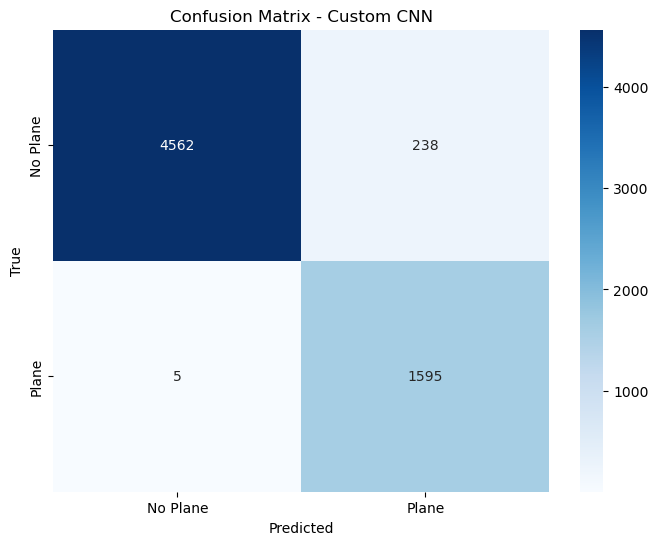

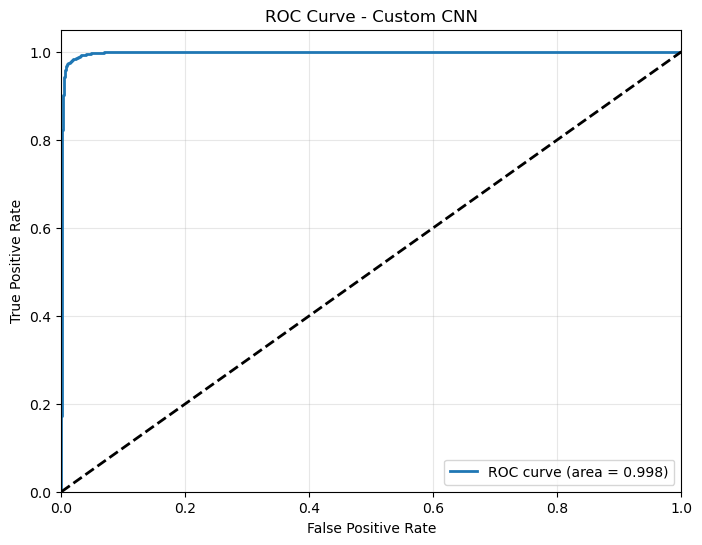

200/200 ━━━━━━━━━━━━━━━━━━━━ 36s 167ms/step
Model: ResNet Transfer Learning
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.74      0.84      4800
           1       0.55      0.96      0.70      1600

    accuracy                           0.80      6400
   macro avg       0.77      0.85      0.77      6400
weighted avg       0.87      0.80      0.81      6400



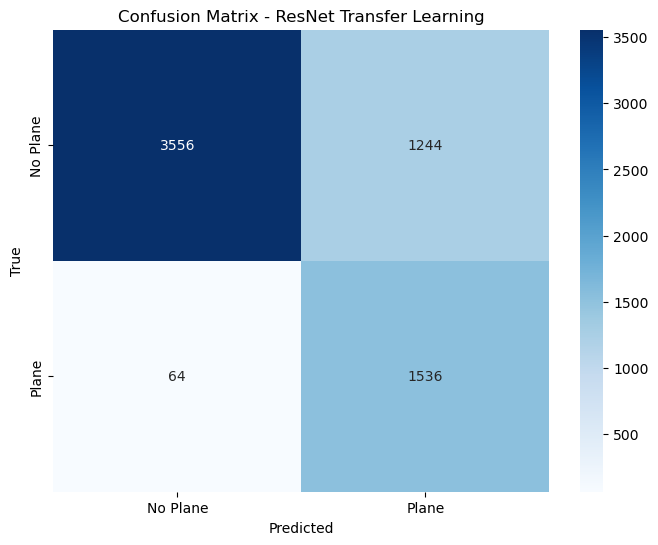

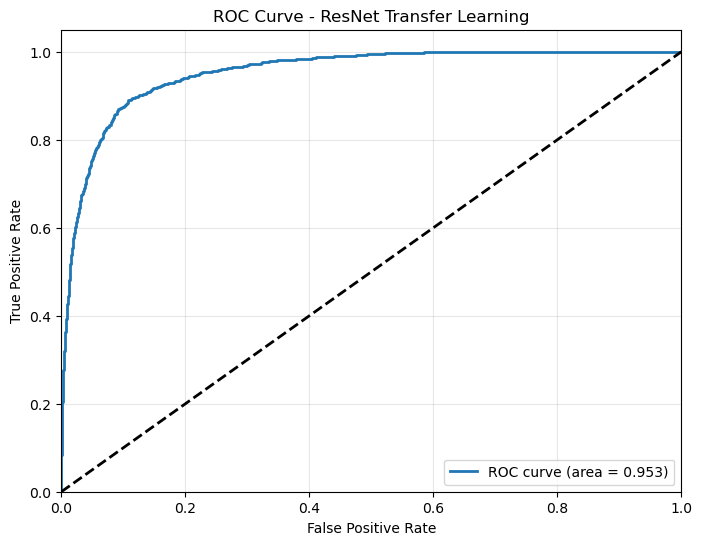

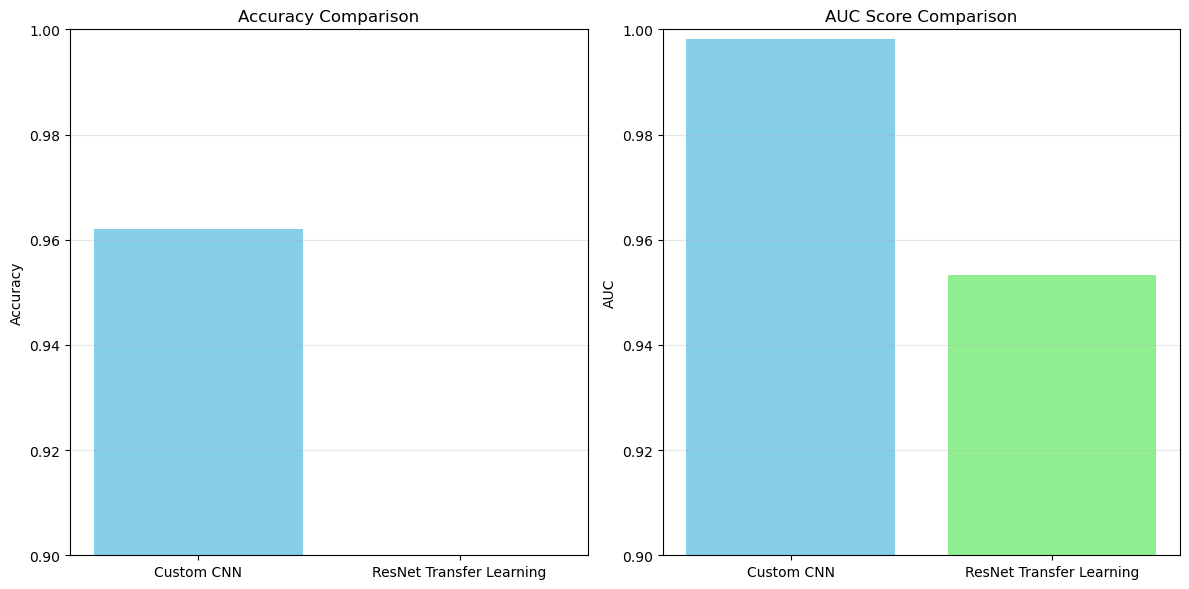

In [13]:
# Function to evaluate a model and display results
def evaluate_model(model, X_test, y_test, model_name):
    # Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Calculate metrics
    accuracy = np.mean(y_pred == y_test)
    
    # Print classification report
    print(f"Model: {model_name}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Plane', 'Plane'],
                yticklabels=['No Plane', 'Plane'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_prob': y_pred_prob
    }

# Load the best models (which were saved during training)
best_custom_cnn = tf.keras.models.load_model('best_custom_cnn.keras')
best_resnet_model = tf.keras.models.load_model('best_resnet_model.keras')

# Evaluate both models
custom_results = evaluate_model(best_custom_cnn, X_test, y_test, "Custom CNN")
resnet_results = evaluate_model(best_resnet_model, X_test, y_test, "ResNet Transfer Learning")

# Compare model performances
models = ['Custom CNN', 'ResNet Transfer Learning']
accuracies = [custom_results['accuracy'], resnet_results['accuracy']]
auc_scores = [custom_results['roc_auc'], resnet_results['roc_auc']]

# Plot comparison
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(models, accuracies, color=['skyblue', 'lightgreen'])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)  # Adjust as needed
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(models, auc_scores, color=['skyblue', 'lightgreen'])
plt.title('AUC Score Comparison')
plt.ylabel('AUC')
plt.ylim(0.9, 1.0)  # Adjust as needed
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 5.2 Applying Models to Full Scenes

here
Processing Scene 1...
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


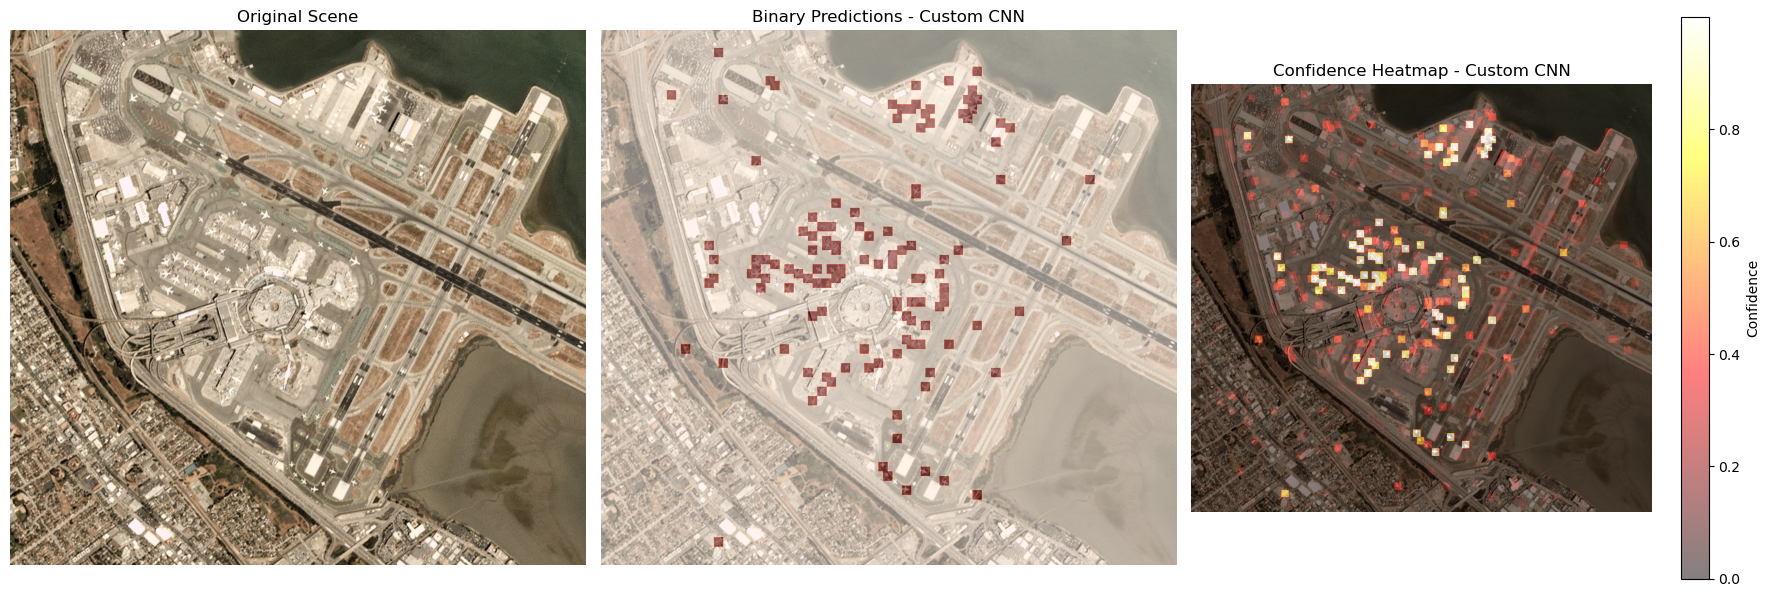

106/106 ━━━━━━━━━━━━━━━━━━━━ 74s 672ms/step


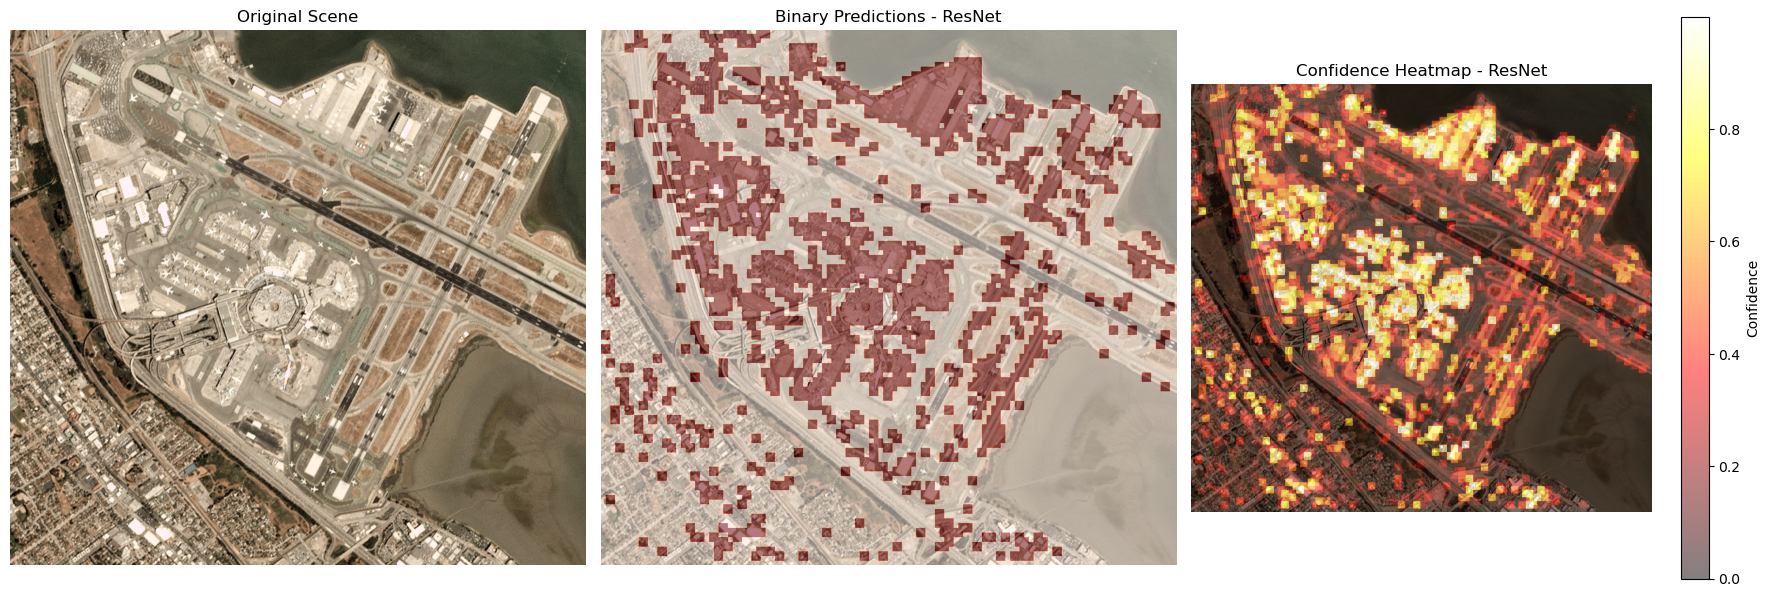

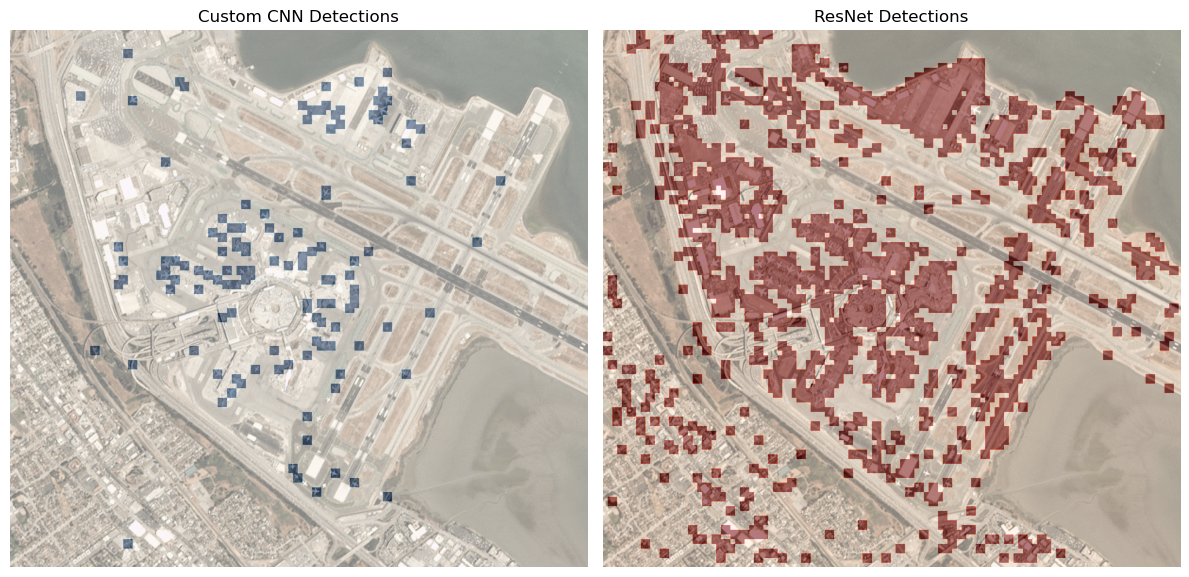

In [14]:
# Function to load a full scene image
def load_scene(scene_path):
    scene = plt.imread(scene_path)
    return scene

# Function to apply model to a scene using sliding window
def apply_model_to_scene_batched(model, scene, window_size=20, stride=10, batch_size=128, threshold=0.3, normalize_confidence=False):
    height, width, _ = scene.shape
    predictions = np.zeros((height, width))
    confidence = np.zeros((height, width))
    count_map = np.zeros((height, width))

    windows = []
    positions = []

    # Collect windows and their positions
    for y in range(0, height - window_size + 1, stride):
        for x in range(0, width - window_size + 1, stride):
            window = scene[y:y+window_size, x:x+window_size, :]
            windows.append(window)
            positions.append((y, x))

    windows = np.array(windows)

    # Predict in batches
    preds = model.predict(windows, batch_size=batch_size, verbose=1)

    # Fill prediction and confidence maps
    for idx, (y, x) in enumerate(positions):
        pred_value = preds[idx][0]
        binary = float(pred_value > threshold)

        # Binary prediction map (additive)
        predictions[y:y+window_size, x:x+window_size] += binary
        count_map[y:y+window_size, x:x+window_size] += 1

        # Confidence heatmap (max method instead of additive)
        confidence[y:y+window_size, x:x+window_size] = np.maximum(
            confidence[y:y+window_size, x:x+window_size], pred_value
        )

    count_map = np.maximum(count_map, 1)
    predictions /= count_map

    if normalize_confidence:
        confidence /= count_map

    return predictions, confidence


# Function to visualize model predictions on a scene
def visualize_scene_predictions(scene, predictions, confidence, threshold=0.1, model_name=""):
    # Create a figure with 3 subplots
    plt.figure(figsize=(18, 6))
    
    # Original scene
    plt.subplot(1, 3, 1)
    plt.imshow(scene)
    plt.title("Original Scene")
    plt.axis('off')
    
    # Binary predictions
    plt.subplot(1, 3, 2)
    binary_pred = predictions > threshold
    plt.imshow(scene)
    plt.imshow(binary_pred, alpha=0.5, cmap='Reds')
    plt.title(f"Binary Predictions - {model_name}")
    plt.axis('off')
    
    # Confidence heatmap
    plt.subplot(1, 3, 3)
    plt.imshow(scene)
    plt.imshow(confidence, alpha=0.5, cmap='hot')
    plt.colorbar(label='Confidence')
    plt.title(f"Confidence Heatmap - {model_name}")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Load scenes
scene_paths = ['scenes/scenes/scene_1.png']  
scenes = [load_scene(path) for path in scene_paths]
print('here')
# Apply both models to each scene
for i, scene in enumerate(scenes):
    print(f"Processing Scene {i+1}...")
    
    # Apply Custom CNN
    custom_predictions, custom_confidence = apply_model_to_scene_batched(best_custom_cnn, scene, threshold=0.3)
    visualize_scene_predictions(scene, custom_predictions, custom_confidence, model_name="Custom CNN")
    
    # Apply ResNet
    resnet_predictions, resnet_confidence = apply_model_to_scene_batched(best_resnet_model, scene, threshold=0.3)
    visualize_scene_predictions(scene, resnet_predictions, resnet_confidence, model_name="ResNet")
    
    # Compare detections from both models
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(scene)
    plt.imshow((custom_predictions > 0.1), alpha=0.5, cmap='Blues')
    plt.title("Custom CNN Detections")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(scene)
    plt.imshow((resnet_predictions > 0.1), alpha=0.5, cmap='Reds')
    plt.title("ResNet Detections")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

## Discussion and Conclusion
In this project, I developed deep learning models to detect aircraft in satellite imagery. I explored two approaches: a custom CNN architecture designed for this task and a transfer learning approach using the pre-trained ResNet50 model.

Key Findings
My initial results showed that both models achieved high accuracy in identifying aircraft in the 20x20 pixel satellite images. The custom CNN model proved to be efficient and well-suited to the small image size, while the ResNet transfer learning approach leveraged pre-trained weights to achieve comparable performance despite being originally designed for much larger images. I imagine that the lower accuracy and other metrics from the ResNet50 model came from the fact that I had to upscale a smaller image to work with it. 

The class imbalance in the dataset (8,000 "plane" vs. 24,000 "no-plane" images) was addressed using class weights during training, resulting in balanced precision and recall scores for both models.

When applied to full satellite scenes, both models successfully identified aircraft, though with some differences in their detection patterns. The custom CNN tended to produce more focused detections with fewer false positives, while the ResNet model exhibited higher sensitivity but also more false positives.

Challenges and Limitations
I encountered several challenges during this project:

 1. Small Image Size: The 20x20 pixel size of the images limits the amount of detail available, making it challenging to distinguish aircraft from similar-looking objects. This is apparent in the case of the ResNet model where was much less accurate when classifying on an entire image. 

 2. False Positives: Both models occasionally misclassified certain ground features (like road intersections or building corners) as aircraft, particularly when these features exhibited linear structures resembling wings. Another problem given the small size of the image, but also realistic as satellite images have a wide swatch of pixel to meter ratio. 

Incorporating additional data sources, such as infrared or radar imagery, could improve detection in challenging conditions for any future models, as well as a faster model optimized for quicker detection techniques. Using vectorization via batching when applyng the model also made it very fast. 

This project demonstrates the effectiveness of deep learning approaches for aircraft detection in satellite imagery. Both my custom CNN and the transfer learning approach with ResNet achieved strong performance, highlighting the flexibility of deep learning methods for specialized computer vision tasks. Although the ResNet model could certainly benefit from more training. 